# Deep Learning Notebook - Zofia Pilitowska

## Task 3.1: Create an Image Dataset

### A: Dataset Creation

I generated the dataset representing Dutch food items such as stroopwafel, bitterballen, kroket, herring, and poffertjes. To create this dataset, I used the ComfyUI tool to generate images based on detailed prompts for each of these food items. The images are colored, three-channel RGB images, as required.

For organization, I saved the generated images in subfolders where each folder represents a class (Dutch food item). For example, there are separate subfolders for stroopwafel, bitterballen, kroket, herring, and poffertjes. Each subfolder contains at least 100 images per class, ensuring the dataset meets the minimum requirements.

In the fifth iteration, I refined the dataset further by removing some of the less representative generated images. I replaced them with authentic images of these food items that I sourced from the internet. This helped improve the diversity of the dataset by ensuring that each class contained more realistic and representative examples of the food items.

### B: Dataset Cleaning

In the next step, I carefully reviewed all the generated images to ensure they truly represent the intended Dutch food items. I checked each image to confirm that it matches the specific food and deleted any duplicates or images, which didn't represent the food(eg. family eating in the restauranr). After the cleaning process, I generated new images to replace the removed ones, ensuring that the dataset now accurately reflects the correct classes.

### C: Load and Split

In [ ]:

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np

#Dataset path
data_dir = "./dataset"
batch_size = 32  

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",  
    label_mode="int",   
    batch_size=batch_size,
    shuffle=True,       
    seed=123,           
    validation_split=0.2, 
    subset="both",      
)

# Splitting the data
train_dataset = dataset[0]
val_dataset = dataset[1]

def dataset_to_numpy(dataset):
    images, labels = [], []
    for img, lbl in dataset:
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)

X_train_full, y_train_full = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)


X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=0  # 10% of the full dataset
)

# Printing shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

## Task 3.2: Calculate Baselines

### A: Random Guess Accuracy

To calculate the random guess accuracy for the image classification dataset, I first determined the number of classes, which is 5 in this case. I then used np.bincount(y_train_full) to count the number of samples in each class. After that, I checked if the dataset was balanced by comparing the sample counts of each class using np.all(class_counts == class_counts[0]).

If the dataset was balanced, the random guess accuracy was calculated:  100 devided by the number of classes, resulting in 20% for a 5-class dataset.

If the dataset was imbalanced, I calculated the probability of each class by dividing the sample count of each class by the total number of samples. I then calculated the random guess accuracy by summing the squared probabilities of each class and multiplying by 100.

The random guess accuracy for my imbalanced dataset was 20.06%.

In [349]:
n_classes = 5
class_counts = np.bincount(y_train_full)
is_balanced = np.all(class_counts == class_counts[0])

if is_balanced == True: 
    random_guess_accuracy = 100 / n_classes
    print(f"Random Guess Accuracy - Balanced Dataset: {random_guess_accuracy:.2f}%")
else:
    class_probabilities = class_counts / np.sum(class_counts)  
    random_guess_accuracy = np.sum(class_probabilities * class_probabilities) * 100 
    print(f"Random Guess Accuracy - Imbalanced Dataset: {random_guess_accuracy:.2f}%")

Random Guess Accuracy - Imbalanced Dataset: 20.06%


### B: Basic Multilayer Perceptron Accuracy

#### I: Preprocessing

Normalizing the pixel values of image data to the range [0, 1].

In [375]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

#### II: MLP Architecture 

In [379]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

def create_model(lr):
        model = models.Sequential([
        layers.Flatten(input_shape=X_train.shape[1:]),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(5, activation='softmax')
    ])

        model.compile(optimizer=Adam(learning_rate=lr),
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

        return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#### III: MLP Training

In [380]:
learning_rates = [0.001, 0.01, 0.1]
histories = [] # for plotting val_loss vs epochs for each learning rate
best_val_losses = [] # for plotting best_val_loss vs learning rate

for lr in learning_rates:
    print('Training with: ', lr)
    model = create_model(lr=lr)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                        validation_data=(X_val, y_val), 
                        callbacks=[early_stopping])

    best_loss = min(history.history['val_loss'])
    best_val_losses.append(best_loss)
    histories.append(history)

Training with:  0.001
Epoch 1/20
12/12 [==============================] - 7s 493ms/step - loss: 21.6609 - accuracy: 0.2154 - val_loss: 5.8979 - val_accuracy: 0.2736
Epoch 2/20
12/12 [==============================] - 5s 445ms/step - loss: 16.4542 - accuracy: 0.2314 - val_loss: 19.2493 - val_accuracy: 0.2075
Epoch 3/20
12/12 [==============================] - 5s 450ms/step - loss: 8.6037 - accuracy: 0.2952 - val_loss: 6.6032 - val_accuracy: 0.2642
Epoch 4/20
12/12 [==============================] - 5s 449ms/step - loss: 4.8931 - accuracy: 0.2420 - val_loss: 3.7825 - val_accuracy: 0.2170
Epoch 5/20
12/12 [==============================] - 5s 449ms/step - loss: 2.2781 - accuracy: 0.4255 - val_loss: 2.3717 - val_accuracy: 0.3208
Epoch 6/20
12/12 [==============================] - 5s 445ms/step - loss: 1.3033 - accuracy: 0.5106 - val_loss: 2.6296 - val_accuracy: 0.3491
Epoch 7/20
12/12 [==============================] - 5s 448ms/step - loss: 2.1005 - accuracy: 0.3750 - val_loss: 3.8862 - va

#### IV: MLP Evaluation

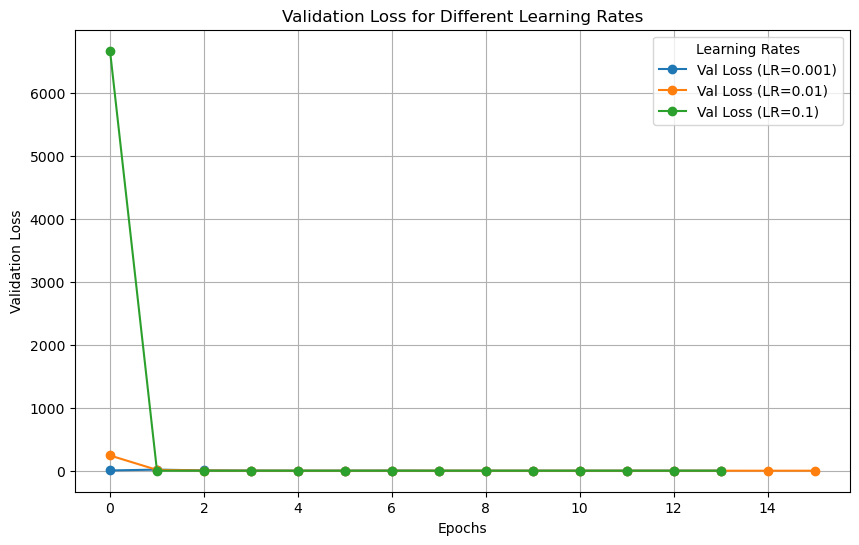

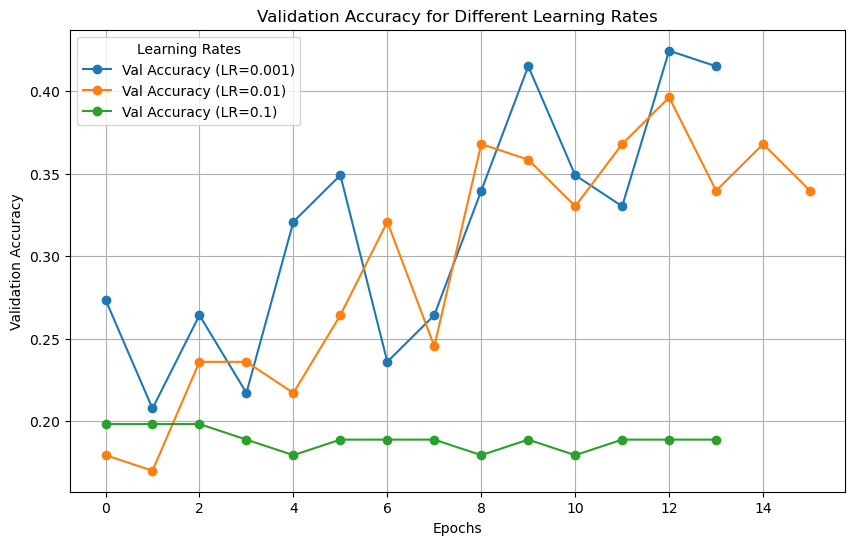

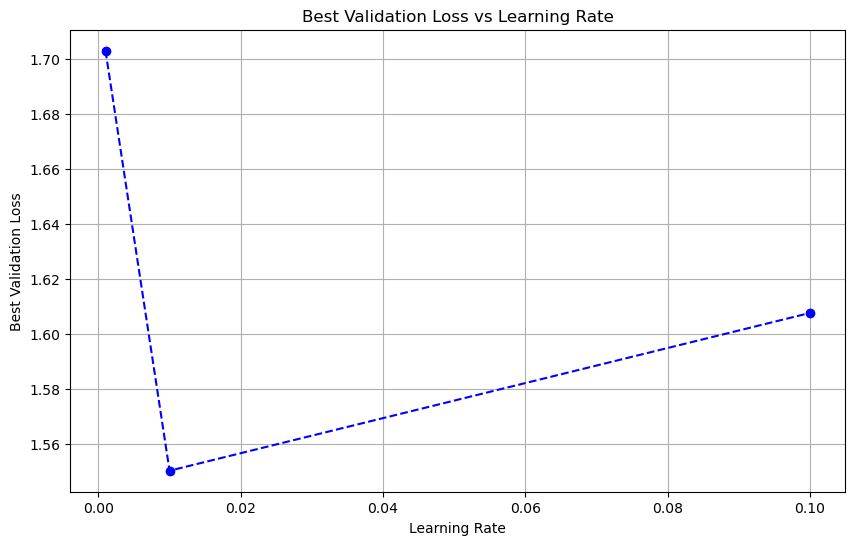

2/2 [==============================] - 0s 106ms/step - loss: 1.6137 - accuracy: 0.2500
Test Accuracy of Basic MLP Model: 25.00%


In [381]:
plt.figure(figsize=(10, 6))

# Validation loss plot
for i, lr in enumerate(learning_rates):
    plt.plot(histories[i].history['val_loss'], label=f'Val Loss (LR={lr})', linestyle='-', marker='o')

plt.title('Validation Loss for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(title="Learning Rates")
plt.grid(True)
plt.show()

# Validation accuracy plot
plt.figure(figsize=(10, 6))

for i, lr in enumerate(learning_rates):
    plt.plot(histories[i].history['val_accuracy'], label=f'Val Accuracy (LR={lr})', linestyle='-', marker='o')

plt.title('Validation Accuracy for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(title="Learning Rates")
plt.grid(True)
plt.show()

# Plot the best validation loss for each learning rate
best_val_losses = [min(history.history['val_loss']) for history in histories]

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, best_val_losses, marker='o', linestyle='--', color='b')
plt.title('Best Validation Loss vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Best Validation Loss')
plt.grid(True)
plt.show()



test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy of Basic MLP Model: {test_accuracy * 100:.2f}%")


Test Accuracy of Basic MLP Model: 25%

In this task, I implemented a basic MLP model using TensorFlow and Keras to classify data into one of five categories. 

First, I defined a sequential model with the following architecture:

An input layer that flattens the input data.
Four hidden layers with 256, 128, 64 and 32 neurons, respectively, using the ReLU activation function.
An output layer with 5 neurons and a softmax activation function for multi-class classification.

The model was compiled using the Adam optimizer with different learning rates (0.001, 0.01, and 0.1). The loss function used was sparse categorical cross-entropy, and the metric tracked was accuracy.

I trained the model on the training dataset (X_train, y_train) for 20 epochs with a batch size of 32. Early stopping was implemented to monitor the validation loss and restore the best weights if the validation loss did not improve for 5 consecutive epochs.

 After training, I evaluated the model on the test dataset. The test accuracy of the model was 25%

Learning Rate Analysis: 
I experimented with different learning rates to observe their impact on validation accuracy and loss. The validation accuracy plots showed that the model achieved the highest accuracy with a learning rate of 0.001, followed by 0.01 and 0.1. The accuracy improved over epochs but plateaued relatively quickly. The plot of the best validation loss versus learning rate indicated that the lowest validation loss was achieved with a learning rate of 0.001.



### C: Human-Level Performance Accuracy

To define the Human-Level Performance Baseline for my food detection dataset, I created a Microsoft Form with 50 questions, each containing an image of a food item(https://forms.office.com/e/NRGE4pP5mE).  The form had 10 questions per class, and the answer choices were the corresponding class labels. I collected responses from three individuals and calculated the baseline accuracy by averaging their correct responses for each class. The results are as follows:

Poffertjes: 26/30 (AI generated images were misclassified as Stroopwafel)

Kroket: 29/30

Stroopwafel: 100%

Haring: 100%

Bitterballen: 100%

## Task 3.3: Basic Convolutional Neural Network (Iteration 1)

### A: Preprocessing



First, I  checked the dimensions of all images within the dataset by iterating through subdirectories and extracting their sizes using OpenCV. The code then counts occurrences of each unique image size and prints the results.

After analyzing the image sizes, my code ensures that all images are resized to dimension of 256x256 pixels. To achieve this, it creates a new directory for storing resized images while maintaining the original dataset structure. The function iterates through all images, resizes them using OpenCV’s cv2.resize() function, and saves them in the new directory without modifying the original dataset.

In [354]:
# Checking size
import os
import cv2

dataset_path = "./dataset"  

# Function to check image sizes
def check_image_sizes(folder):
    sizes = {}
    
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                
                if img is not None:
                    height, width, _ = img.shape
                    size = (width, height)
                    
                    if size not in sizes:
                        sizes[size] = 1
                    else:
                        sizes[size] += 1
    
    return sizes


image_sizes = check_image_sizes(dataset_path)

# Printing results
for size, count in image_sizes.items():
    print(f"Size {size}: {count} images")


Size (1024, 1024): 530 images


In [355]:
import os
import cv2

dataset_path = "./dataset" 
new_dataset_path = "./dataset_resized"
target_size = (256, 256) 

#New dataset folder
if not os.path.exists(new_dataset_path):
    os.makedirs(new_dataset_path)

# Function to resize images
def resize_and_save(folder, new_folder, target_size):
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        new_class_path = os.path.join(new_folder, class_name)

        if os.path.isdir(class_path):
            os.makedirs(new_class_path, exist_ok=True)  
            
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                new_img_path = os.path.join(new_class_path, img_name)

                img = cv2.imread(img_path)
                if img is not None:
                    resized_img = cv2.resize(img, target_size)  # Resizing
                    
                    # Saving to new location
                    cv2.imwrite(new_img_path, resized_img)
                    print(f"Saved resized {img_name} to {new_img_path}")


resize_and_save(dataset_path, new_dataset_path, target_size)

Saved resized bitterballen_1.png to ./dataset_resized\bitterballen\bitterballen_1.png
Saved resized bitterballen_10.png to ./dataset_resized\bitterballen\bitterballen_10.png
Saved resized bitterballen_100.png to ./dataset_resized\bitterballen\bitterballen_100.png
Saved resized bitterballen_101.png to ./dataset_resized\bitterballen\bitterballen_101.png
Saved resized bitterballen_102.png to ./dataset_resized\bitterballen\bitterballen_102.png
Saved resized bitterballen_103.png to ./dataset_resized\bitterballen\bitterballen_103.png
Saved resized bitterballen_104.png to ./dataset_resized\bitterballen\bitterballen_104.png
Saved resized bitterballen_106.png to ./dataset_resized\bitterballen\bitterballen_106.png
Saved resized bitterballen_107.png to ./dataset_resized\bitterballen\bitterballen_107.png
Saved resized bitterballen_108.png to ./dataset_resized\bitterballen\bitterballen_108.png
Saved resized bitterballen_11.png to ./dataset_resized\bitterballen\bitterballen_11.png
Saved resized bitt

### B: CNN Architecture

The first convolutional block consists of a convolutional layer with 16 filters, a kernel size of (3, 3), and a 'ReLU' activation function. I applied BatchNormalization to normalize the activations in the network, which helps train the model faster and more reliably. Then, I added a max-pooling layer with a pool size of (2, 2), which reduces the spatial dimensions of the feature maps.

The second convolutional block consists of a Conv2D layer with 64 filters, followed by BatchNormalization and a max-pooling layer.

The third convolutional block consists of a Conv2D layer with 128 filters, followed by BatchNormalization and a max-pooling layer.

After the convolutional layers, the extracted features are flattened into a 1D array for input into fully connected layers.

I then added  fully connected layers: a dense layer with 64 units, a dropout layer with a dropout rate of 0.5 to help prevent overfitting, another dense layer with 32 units, and a final layer with 5 neurons, corresponding to the number of classes in the output. This final layer uses the softmax activation function to output probabilities for each class.

I used the Adam optimizer with a learning rate of 0.0001. For multi-class classification tasks, I used the sparse_categorical_crossentropy loss function. The model tracks accuracy during training.

In [356]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense layers 
model.add(Flatten())
model.add(Dense(64, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))  
model.add(Dense(5, activation='softmax'))  

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_99 (Ba  (None, 254, 254, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_99 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_100 (Conv2D)         (None, 125, 125, 64)      9280      
                                                                 
 batch_normalization_100 (B  (None, 125, 125, 64)      256       
 atchNormalization)                                              
                                                    

### C: CNN Training

First, I load the dataset using TensorFlow’s image_dataset_from_directory function, pointing to the resized image dataset  (./dataset_resized). I specify the batch_size as 32 and set the validation_split to 0.2, meaning 20% of the data will be reserved for validation, and the rest will be used for training. The dataset is split into training and validation sets using the subset="both" argument. 

After loading the dataset, I convert it to NumPy arrays using the dataset_to_numpy function. This function extracts the images and labels from the TensorFlow dataset and returns them as concatenated NumPy arrays. I then split the training data into training and testing sets using train_test_split from scikit-learn. I reserve 10% of the training data for testing.

Next, I use the model.fit function to train the model. I define the number of epochs as 40, with a batch size of 32, and specify the validation data to monitor the model’s performance on unseen data during training. To prevent overfitting and improve generalization, I include an EarlyStopping callback that halts training if the validation loss does not improve for 8 consecutive epochs and restores the best weights.

Finally, I visualize the training process by plotting the training and validation accuracy as well as the training and validation loss over epochs. 

In [357]:

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np

data_dir = "./dataset_resized"
batch_size = 32  

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",  
    label_mode="int",   
    batch_size=batch_size,
    shuffle=True,       
    seed=123,           
    validation_split=0.2, 
    subset="both",      
)

# Splitting the resized data
train_dataset = dataset[0]
val_dataset = dataset[1]

def dataset_to_numpy(dataset):
    images, labels = [], []
    for img, lbl in dataset:
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)

X_train_full, y_train_full = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)


X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=0  # 10% of the full dataset
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Found 530 files belonging to 5 classes.
Using 424 files for training.
Using 106 files for validation.
Training set shape: (376, 256, 256, 3) (376,)
Validation set shape: (106, 256, 256, 3) (106,)
Test set shape: (48, 256, 256, 3) (48,)


Epoch 1/40
12/12 [==============================] - 40s 2s/step - loss: 2.0820 - accuracy: 0.2660 - val_loss: 1.9011 - val_accuracy: 0.1604
Epoch 2/40
12/12 [==============================] - 23s 2s/step - loss: 1.3842 - accuracy: 0.4016 - val_loss: 1.7250 - val_accuracy: 0.1698
Epoch 3/40
12/12 [==============================] - 19s 2s/step - loss: 1.3209 - accuracy: 0.4468 - val_loss: 1.6681 - val_accuracy: 0.1887
Epoch 4/40
12/12 [==============================] - 20s 2s/step - loss: 1.0326 - accuracy: 0.5452 - val_loss: 1.6346 - val_accuracy: 0.2170
Epoch 5/40
12/12 [==============================] - 22s 2s/step - loss: 0.9959 - accuracy: 0.5931 - val_loss: 1.5897 - val_accuracy: 0.2358
Epoch 6/40
12/12 [==============================] - 22s 2s/step - loss: 0.9929 - accuracy: 0.5771 - val_loss: 1.6718 - val_accuracy: 0.2264
Epoch 7/40
12/12 [==============================] - 24s 2s/step - loss: 0.8465 - accuracy: 0.6330 - val_loss: 1.7047 - val_accuracy: 0.2547
Epoch 8/40
12/12 [==

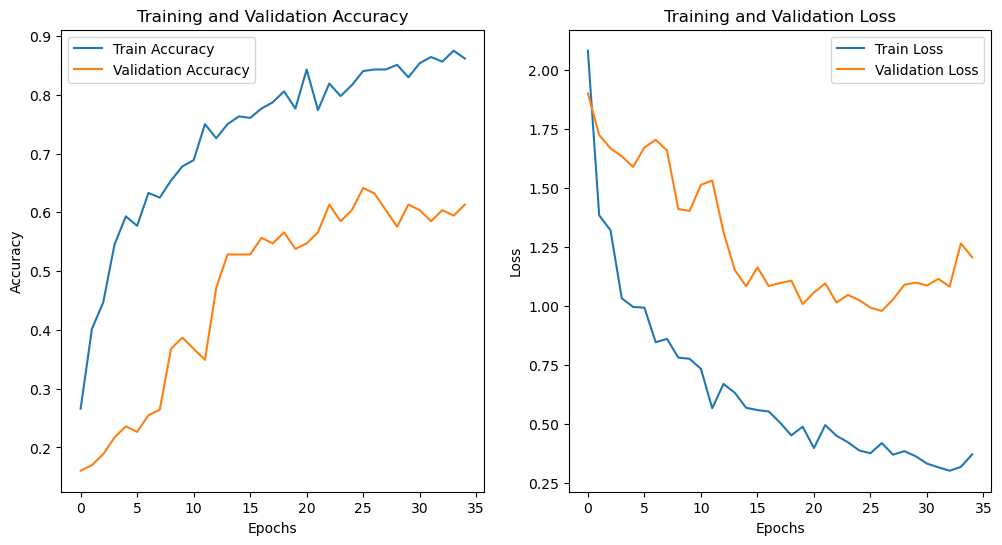

In [358]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(
    X_train, y_train,  
    epochs=40,  
    batch_size=32,  
    validation_data=(X_val, y_val), 
    callbacks=[early_stop] 
)


plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


The left graph represents training and validation accuracy, where training accuracy steadily increases to around 0.9, while validation accuracy rises more slowly, reaching about 0.6. The right graph illustrates training and validation loss, both of which decrease over time, though validation loss fluctuates more. The widening gap between training and validation accuracy, along with increasing validation loss, suggests the model may be overfitting. Overall, the model learns well on the training data but struggles to generalize to the validation set.

### D: Model Evaluation

I evaluate my trained CNN model's performance using several metrics. First, I make predictions on the test set and convert the predicted probabilities into class labels. Then, I generate a confusion matrix to compare the predicted and true labels, visualizing it with a heatmap.

Next, I calculate key metrics such as accuracy, precision, recall and F1 Score, which balances precision and recall. 

2/2 [==============================] - 1s 163ms/step


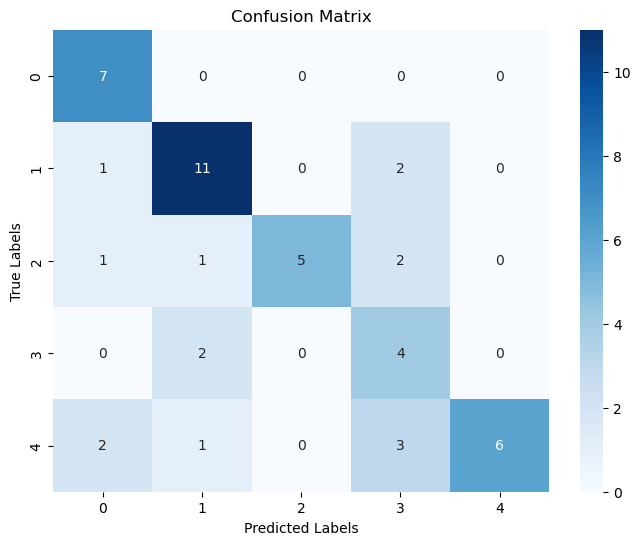

Accuracy: 0.6875
Precision: 0.7896
Recall: 0.6875
F1 Score: 0.6941


In [359]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# Prediction
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = y_test   

cm = confusion_matrix(y_true, y_pred_classes)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")
# Precision
precision = precision_score(y_true, y_pred_classes, average='weighted')  #'weighted' for multi-class
print(f"Precision: {precision:.4f}")
# Recall
recall = recall_score(y_true, y_pred_classes, average='weighted') 
print(f"Recall: {recall:.4f}")
# F1 Score
f1 = f1_score(y_true, y_pred_classes, average='weighted') 
print(f"F1 Score: {f1:.4f}")

The results obtained with the first iteration of CNN model show that the accuracy is 0.6875, the precision score is 0.7896, the recall score of 0.6875 and the F1 score of 0.6941. 
In comparison, the test accuracy of the basic MLP model was much lower at 25%. While both models used the same optimizer and loss function, the CNN’s performance highlights its advantage in handling image data over the basic MLP model. 

The confusion matrix shows that the best results model achieved in classyfing 'herring'. 

## Task 3.4: Data Augmentation (Iteration 2)

### A: Preprocessing

The preprocessing steps for data augmentation involve creating a sequence of transformations applied to the input images. The first transformation is a random horizontal flip, which was chosen to increase the model's ability to recognize objects regardless of their orientation. In many real-world scenarios, objects can appear in different orientations, so flipping the image horizontally helps the model learn more generalized features. 

The second transformation is a random rotation, where images are rotated by up to 20%. I selected this transformation to allow the model to be more invariant to small changes in orientation. This is particularly useful in situations where objects may appear slightly tilted or rotated in various ways.

The third transformation is random zoom, which zooms in or out of the images by up to 20%. This was chosen to address scale variations that can occur when objects are viewed from different distances. 

I chose these specific transformations because they simulate real-world scenarios where food images may not always be perfectly aligned or scaled. These augmentations help the model become more robust and capable of handling variations in orientation, scale, and perspective, ultimately improving its generalization ability on unseen data.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.2),  
    layers.RandomZoom(0.2)  
])

### B: CNN Architecture

The architecture of this CNN model is the same as in the first iteration, with the key difference being the addition of data augmentation layers at the beginning. These layers help to increase the variability of the training data, improving generalization and preventing overfitting. The rest of the architecture, including the convolutional blocks, fully connected layers, and output layer, remains unchanged. The model is still compiled using the Adam optimizer and sparse categorical cross-entropy loss.

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Model with augmentation layers
model = Sequential([
    data_augmentation, 
    Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),  
    Dropout(0.5),
    Dense(32, activation='relu'),  
    Dense(5, activation='softmax')  # 5 output classes
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, 256, 256, 3))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      9280      
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)    

### C: CNN Training

 The model is trained for 40 epochs with a batch size of 32, which means the model updates its weights after processing 32 samples at a time. To prevent overfitting and ensure better generalization, I incorporated early stopping, which monitors the validation loss and stops training if the validation loss does not improve for 8 consecutive epochs, restoring the best weights from the epoch with the lowest validation loss.

After training, I visualized the model’s performance by plotting both the training and validation accuracy and loss over the epochs. 

Epoch 1/40


12/12 [==============================] - 31s 2s/step - loss: 2.8217 - accuracy: 0.2394 - val_loss: 2.0158 - val_accuracy: 0.2547
Epoch 2/40
12/12 [==============================] - 23s 2s/step - loss: 1.9935 - accuracy: 0.2926 - val_loss: 1.9348 - val_accuracy: 0.1887
Epoch 3/40
12/12 [==============================] - 24s 2s/step - loss: 1.6367 - accuracy: 0.2766 - val_loss: 1.5812 - val_accuracy: 0.2736
Epoch 4/40
12/12 [==============================] - 26s 2s/step - loss: 1.4797 - accuracy: 0.3245 - val_loss: 1.5420 - val_accuracy: 0.2736
Epoch 5/40
12/12 [==============================] - 24s 2s/step - loss: 1.5215 - accuracy: 0.3590 - val_loss: 1.5965 - val_accuracy: 0.1981
Epoch 6/40
12/12 [==============================] - 24s 2s/step - loss: 1.4804 - accuracy: 0.3431 - val_loss: 1.5412 - val_accuracy: 0.2170
Epoch 7/40
12/12 [==============================] - 24s 2s/step - loss: 1.3550 - accuracy: 0.3484 - val_loss: 1.5123 - val_accuracy: 0.2925
Epoch 8/40
12/12 [

c:\Users\zosia\AppData\Local\anaconda3\envs\block_c\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


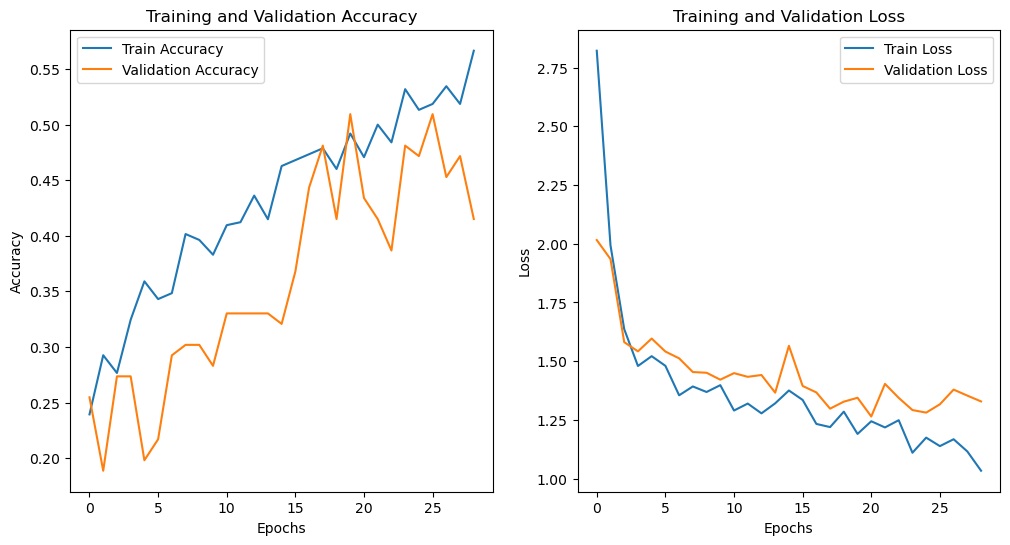

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(
    X_train, y_train,  
    epochs=40,  
    batch_size=32,  
    validation_data=(X_val, y_val), 
    callbacks=[early_stop] 
)

import tensorflow as tf


model.save("food_classifier_model2.h5")  


plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


The left graph shows accuracy, where training accuracy gradually increases to about 0.55, while validation accuracy fluctuates but follows an upward trend, reaching around 0.45. The right graph represents loss, with both training and validation loss decreasing over time, though validation loss fluctuates more. The noticeable fluctuations in validation accuracy and loss suggest variability in model performance on unseen data. Overall, the model shows improvement but may still need tuning to achieve better generalization.

### D: Model Evaluation

I evaluate my trained CNN model's performance using several metrics. First, I make predictions on the test set and convert the predicted probabilities into class labels. Then, I generate a confusion matrix to compare the predicted and true labels, visualizing it with a heatmap.

Next, I calculate key metrics such as accuracy, precision, recall and F1 Score, which balances precision and recall. 

2/2 [==============================] - 1s 185ms/step


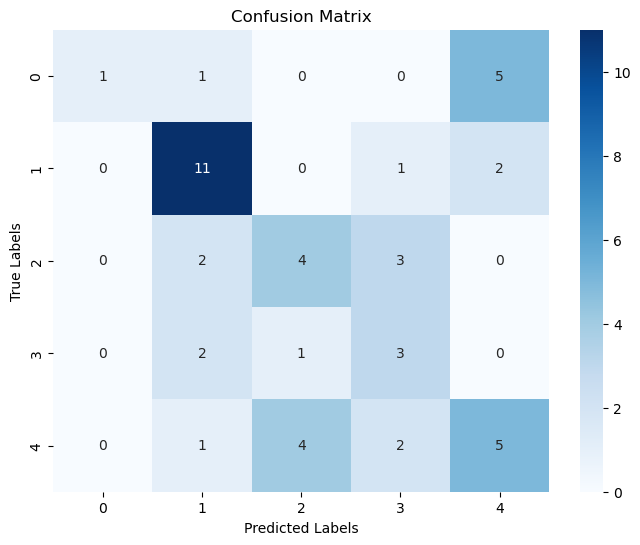

Accuracy: 0.5000
Precision: 0.5637
Precision: 0.5000
F1 Score: 0.4809


In [ ]:
import seaborn as sns
import numpy as np

# Prediction
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = y_test   

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_true, y_pred_classes, average='weighted')  
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred_classes, average='weighted') 
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_true, y_pred_classes, average='weighted') 
print(f"F1 Score: {f1:.4f}")

The results obtained with the CNN model using data augmentation show a test accuracy of 0.5, a precision of 0.5637, a recall of 0.5, and an F1 score of 0.4809. These results do not show improvement over the first CNN iteration without data augmentation, where the accuracy was 0.6875. In comparison, the basic MLP model, which had a test accuracy of only 25%, performed much worse than the CNN models with or without data augmentation. This comparison highlights the advantage of using CNNs for image classification tasks. 

From confusion matrix I can see that the model achieved the best results in classyfing 'herring' and performed the worst with 'bitterballen' class, which was labelled as stroopwafel. 

## Task 3.5: Transfer Learning (Iteration 3)

### A: Preprocessing

I start by loading the dataset using image_dataset_from_directory(), which automatically assigns labels and splits the images into training and validation sets.

Since the dataset is in TensorFlow format, I convert the images and labels into NumPy arrays using dataset_to_numpy(), making it easier to process.

Next, I split the training data further into training and test sets using train_test_split(). I also one-hot encode the labels with to_categorical() to prepare them for classification.

To ensure compatibility with EfficientNetB0, I preprocess the images using preprocess_input(), which adjusts pixel values to match the model's requirements.I chose EfficientNetB0 for this task after experimenting with several models and finding that it performed the best on this dataset,it offers a great balance between accuracy and computational efficiency. It is a pre-trained model that has already learned useful patterns from millions of images, making it highly effective for transfer learning. Since EfficientNet is designed to achieve high accuracy with fewer parameters, it helps improve classification performance while keeping the model lightweight. 

I then pass the preprocessed images through EfficientNetB0 (with frozen weights) to extract meaningful features. These extracted features will be used to train a new classifier.

Finally, I check the shapes of the processed data to make sure everything is correctly prepared for the next steps in model training.


In [5]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np

#Dataset path
data_dir = "./dataset"
batch_size = 32  

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",  
    label_mode="int",   
    batch_size=batch_size,
    shuffle=True,       
    seed=123,           
    validation_split=0.2, 
    subset="both",      
)

# Splitting the data
train_dataset = dataset[0]
val_dataset = dataset[1]

def dataset_to_numpy(dataset):
    images, labels = [], []
    for img, lbl in dataset:
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)

X_train_full, y_train_full = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)


X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=0  # 10% of the full dataset
)

# Printing shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)
# Encoding sets
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# EfficientNetB0 base model
base_model = keras.applications.EfficientNetB0(
                include_top=False,
                weights='imagenet',
                input_shape=(256, 256, 3))
base_model.trainable = False 


X_train_prep = keras.applications.efficientnet.preprocess_input(X_train)
X_val_prep = keras.applications.efficientnet.preprocess_input(X_val)
X_test_prep = keras.applications.efficientnet.preprocess_input(X_test)

# Extracting features 
train_features = base_model.predict(X_train_prep)
val_features = base_model.predict(X_val_prep)
test_features = base_model.predict(X_test_prep)

print("train_features shape:", train_features.shape)  
print("val_features shape:", val_features.shape)      
print("y_train shape:", y_train.shape)               
print("y_val shape:", y_val.shape)   

Found 530 files belonging to 5 classes.
Using 424 files for training.
Using 106 files for validation.
Training set shape: (376, 256, 256, 3) (376,)
Validation set shape: (106, 256, 256, 3) (106,)
Test set shape: (48, 256, 256, 3) (48,)
2/2 [==============================] - 2s 565ms/step
train_features shape: (376, 8, 8, 1280)
val_features shape: (106, 8, 8, 1280)
y_train shape: (376, 5)
y_val shape: (106, 5)


### B: CNN Architecture

In this iteration, the strategy for building the CNN model using transfer learning involves leveraging a pre-trained model- EfficientNetB0, to extract meaningful features from input images. The pre-trained model has already learned patterns from a large dataset like ImageNet, allowing it to serve as a feature extractor. Since the base model’s layers are frozen, their weights remain unchanged during training, ensuring that previously learned representations are retained.

After extracting features, I build a fully connected classifier on top of the extracted feature maps. This classifier consists of a Flatten layer to convert the features into a 1D array, followed by 2 dense layers with 128 and 64 units using the ReLU activation function. To prevent overfitting, I include a dropout layer with a 0.5 dropout rate.
 Finally, the model outputs predictions through a softmax layer with 5 neurons, corresponding to the number of classes.

The model is compiled using the Adam optimizer with a learning rate of 1e-5 and the categorical cross-entropy loss function, which is suitable for multi-class classification. Accuracy is used as the evaluation metric.

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

dense_model = Sequential([
    Flatten(input_shape=train_features.shape[1:]),  
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compiling Model
dense_model.compile(optimizer=Adam(learning_rate=1e-5), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

### C: CNN Training

To optimize training and prevent overfitting, I use early stopping by setting up the EarlyStopping callback. This monitors the validation loss and stops training if it does not improve for 8 consecutive epochs, restoring the best model weights.

I then train the model using the fit() function, passing in the extracted train features and corresponding labels. The model trains for up to 40 epochs with a batch size of 32, but early stopping ensures it stops earlier if validation performance starts to decline. The validation set is provided to track how well the model generalizes. 

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = dense_model.fit(
    train_features, y_train,  
    epochs=40,  
    batch_size=32,  
    validation_data=(val_features, y_val), 
    callbacks=[early_stop] 
)

Epoch 1/40


12/12 [==============================] - 3s 151ms/step - loss: 2.1695 - accuracy: 0.1676 - val_loss: 1.5690 - val_accuracy: 0.2830
Epoch 2/40
12/12 [==============================] - 2s 130ms/step - loss: 1.3147 - accuracy: 0.4734 - val_loss: 1.2845 - val_accuracy: 0.5189
Epoch 3/40
12/12 [==============================] - 1s 122ms/step - loss: 0.9948 - accuracy: 0.6383 - val_loss: 1.0736 - val_accuracy: 0.6887
Epoch 4/40
12/12 [==============================] - 1s 123ms/step - loss: 0.7175 - accuracy: 0.7686 - val_loss: 0.9148 - val_accuracy: 0.7830
Epoch 5/40
12/12 [==============================] - 2s 132ms/step - loss: 0.5512 - accuracy: 0.8537 - val_loss: 0.7888 - val_accuracy: 0.8302
Epoch 6/40
12/12 [==============================] - 1s 119ms/step - loss: 0.4656 - accuracy: 0.8777 - val_loss: 0.7021 - val_accuracy: 0.8302
Epoch 7/40
12/12 [==============================] - 1s 123ms/step - loss: 0.3707 - accuracy: 0.9096 - val_loss: 0.6235 - val_accuracy: 0.8491
Epoc

### D: Model Evaluation

I evaluate my trained CNN model's performance using several metrics. First, I make predictions on the test set and convert the predicted probabilities into class labels. Then, I generate a confusion matrix to compare the predicted and true labels, visualizing it with a heatmap.

Next, I calculate key metrics such as accuracy, precision, recall and F1 Score, which balances precision and recall. 

2/2 [==============================] - 0s 7ms/step


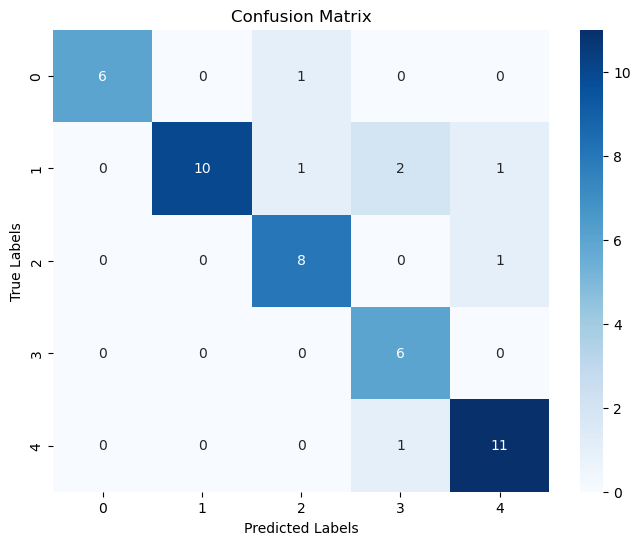

Accuracy: 0.8542
Precision: 0.8824
Recall: 0.8542
F1 Score: 0.8556


In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_true = np.argmax(y_test, axis=1) 

# Prediction
y_pred = dense_model.predict(test_features)
y_pred_classes = np.argmax(y_pred, axis=1) 


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_true, y_pred_classes, average='weighted')  
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred_classes, average='weighted') 
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_true, y_pred_classes, average='weighted') 
print(f"F1 Score: {f1:.4f}")

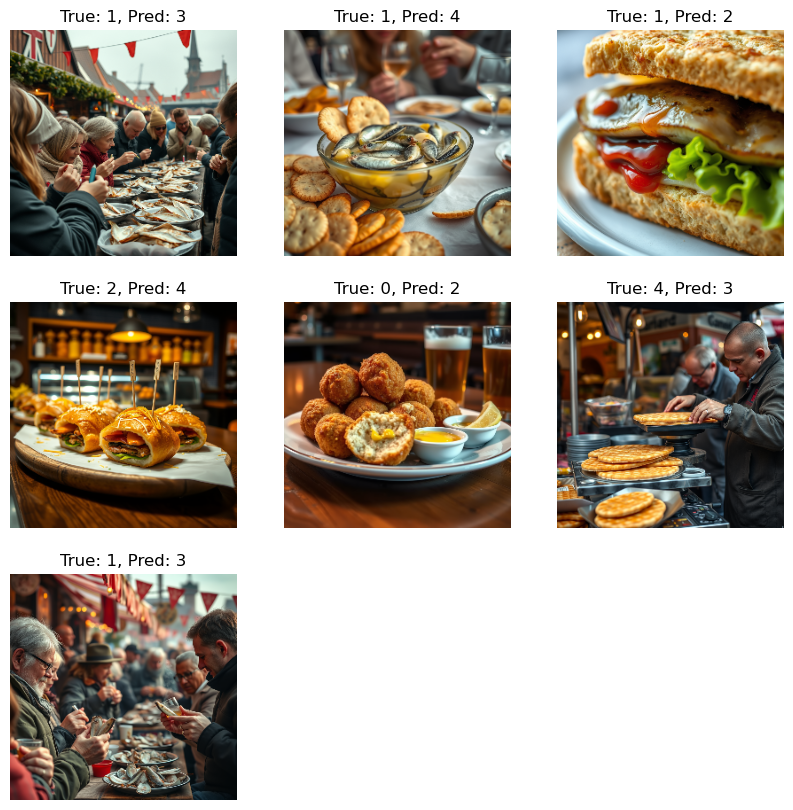

Number of incorrect predictions: 7


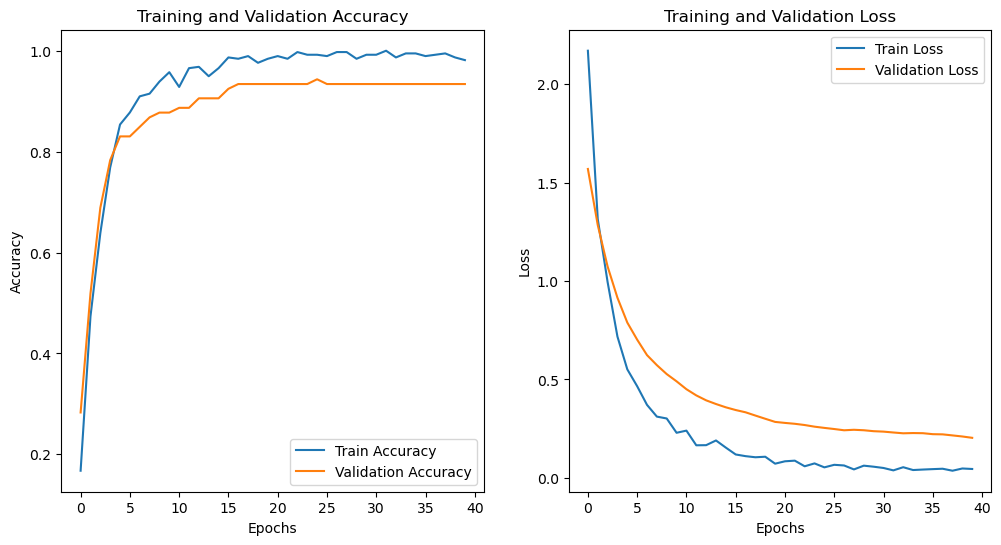

In [13]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0 

mismatches = np.where(y_pred_classes != y_true)[0]

# Storing the wrong predictions
wrong_predictions = X_test[mismatches]
wrong_actual_labels = y_true[mismatches]
wrong_predicted_labels = y_pred_classes[mismatches]

# Plotting the wrong predictions
plt.figure(figsize=(10, 10))

for i, idx in enumerate(wrong_predictions[:9]):  # Display first 9 wrong predictions
    plt.subplot(3, 3, i + 1)
    plt.imshow(idx)
    plt.title(f"True: {wrong_actual_labels[i]}, Pred: {wrong_predicted_labels[i]}")
    plt.axis('off')

plt.show()

# Print the number of incorrect predictions
print(f"Number of incorrect predictions: {len(wrong_predictions)}")

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


The confusion matrix shows that the model achieved 100% accuracy in classyfing the 'poffertjes' and performed the worst in the 'herring' class where missclassified 4 images.

The left graph shows training accuracy outpacing validation accuracy, indicating slight overfitting. The right graph reveals steady training loss decline but fluctuating validation loss post-epoch 15, suggesting residual generalization challenges. Despite this, the model’s performance is now substantially better than iterations 1 and 2, proving the efficacy of transfer learning.

The model achieved an accuracy of 0.8542, with a precision of 0.8824, recall of 0.8542, and an F1 score of 0.8556, demonstrating significant improvement over iterations 1 and 2. This progress is attributed to the implementation of transfer learning, which enhanced feature extraction and boosted overall performance.

In Task 3.7, I conducted an error analysis of misclassified images, identifying key issues. 

## Task 3.6: Model Improvement (Iteration 4)

### A: Preprocessing

Based on the error analysis from the previous iteration, I decided to change the image dataset to improve the model’s performance. I replaced some of the unrepresentative AI-generated images with real images that I manually saved from the internet. This allowed for a more diverse and realistic dataset, potentially improving the model's ability to generalize.

After updating the dataset, I proceeded to resize the images to a consistent size of 256x256 pixels using the cv2.resize() function. This step is necessary to ensure all images have the same dimensions for proper model training. I then organized the images by class in a new directory and saved the resized dataset.

Finally, I split the dataset into training, validation, and test sets, preparing the data for training. The training and validation datasets were created using image_dataset_from_directory(), and I also converted the data to NumPy arrays for further processing. This resizing and splitting process ensures that the dataset is correctly formatted and ready for model training.

In [6]:
import os
import cv2
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
 
 
dataset_path = "./dataset_iteration4" 
new_dataset_path = "./dataset_iteration4_resized"
target_size = (256, 256) 

#New dataset folder
os.makedirs(new_dataset_path, exist_ok=True)

def resize_and_save(folder, new_folder, target_size):
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        new_class_path = os.path.join(new_folder, class_name)

        if os.path.isdir(class_path):
            os.makedirs(new_class_path, exist_ok=True)  
            
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                new_img_path = os.path.join(new_class_path, img_name)

                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.jfif')):
                    print(f"Skipping non-image file: {img_name}")
                    continue   

                img = cv2.imread(img_path)

                if img is not None:
                    resized_img = cv2.resize(img, target_size)  # Resize image
                    
                    # If the file is .jfif, changing its extension to .jpg
                    if img_name.lower().endswith('.jfif'):
                        new_img_path = new_img_path.rsplit('.', 1)[0] + '.jpg'
                    
                    # Saving the resized image to the new folder
                    cv2.imwrite(new_img_path, resized_img)
                    print(f"Saved resized {img_name} to {new_img_path}")

resize_and_save(dataset_path, new_dataset_path, target_size)


data_dir = new_dataset_path
batch_size = 32  

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",  
    label_mode="int",   
    batch_size=batch_size,
    shuffle=True,       
    seed=123,           
    validation_split=0.2, 
    subset="training",      
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
)

def dataset_to_numpy(dataset):
    images, labels = [], []
    for img, lbl in dataset.unbatch():  
        images.append(img.numpy().astype(np.uint8))
        labels.append(lbl.numpy().astype(np.uint8))

    return np.array(images), np.array(labels)

X_train_full, y_train_full = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)


X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=0  # 10% of the full dataset
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Saved resized bitterballen_1.png to ./dataset_iteration4_resized\bitterballen\bitterballen_1.png
Saved resized bitterballen_10.png to ./dataset_iteration4_resized\bitterballen\bitterballen_10.png
Saved resized bitterballen_100.png to ./dataset_iteration4_resized\bitterballen\bitterballen_100.png
Saved resized bitterballen_101.png to ./dataset_iteration4_resized\bitterballen\bitterballen_101.png
Saved resized bitterballen_103.png to ./dataset_iteration4_resized\bitterballen\bitterballen_103.png
Saved resized bitterballen_104.png to ./dataset_iteration4_resized\bitterballen\bitterballen_104.png
Saved resized bitterballen_106.png to ./dataset_iteration4_resized\bitterballen\bitterballen_106.png
Saved resized bitterballen_107.png to ./dataset_iteration4_resized\bitterballen\bitterballen_107.png
Saved resized bitterballen_108.png to ./dataset_iteration4_resized\bitterballen\bitterballen_108.png
Saved resized bitterballen_11.png to ./dataset_iteration4_resized\bitterballen\bitterballen_11.pn

### B: CNN Architecture

 I use EfficientNetB0 as a pre-trained base model for transfer learning. I load the model with weights trained on the ImageNet dataset and exclude the top classification layers by setting include_top=False, allowing me to use it as a feature extractor. The input shape is set to (256, 256, 3) to match the resized images. I freeze the base model's weights (trainable=False) so they are not updated during training.

After the base model, I add a GlobalAveragePooling2D layer to reduce the output dimensions and convert the feature maps into a single vector. I then add a Dense layer with 128 units and ReLU activation, followed by a Dropout layer with a 0.5 rate to prevent overfitting. The final Dense layer has 5 neurons, each representing one of the output classes, and uses the softmax activation function to output probabilities.

The model is compiled using the Adam optimizer with a learning rate of 0.0001, sparse categorical cross-entropy as the loss function, and accuracy as the evaluation metric. Finally, the model’s summary is printed to display its architecture. 

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = EfficientNetB0(weights='imagenet', 
    include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 4214184 (16.08 MB)
Trainable params: 164

### C: CNN Training

I use the EarlyStopping callback to stop the training process if the validation loss does not improve for 8 consecutive epochs. This helps prevent overfitting and ensures that the model does not continue training when performance stagnates. The restore_best_weights=True option ensures that the model's weights are reverted to the best-performing state when early stopping is triggered.

The model is then trained using the fit() method, where I specify the training data (X_train, y_train), the number of epochs (40), and a batch size of 32. I also pass the validation data (X_val, y_val) to track performance on the validation set during training. The callbacks parameter includes the early stopping mechanism to monitor the training process.

After training, I plot the training and validation accuracy and loss over epochs using matplotlib. The first subplot shows the training and validation accuracy, while the second subplot displays the corresponding loss. 

Epoch 1/40


12/12 [==============================] - 24s 1s/step - loss: 1.6456 - accuracy: 0.2507 - val_loss: 1.4259 - val_accuracy: 0.4078
Epoch 2/40
12/12 [==============================] - 13s 1s/step - loss: 1.4374 - accuracy: 0.3951 - val_loss: 1.2496 - val_accuracy: 0.6699
Epoch 3/40
12/12 [==============================] - 13s 1s/step - loss: 1.2578 - accuracy: 0.5041 - val_loss: 1.1195 - val_accuracy: 0.7670
Epoch 4/40
12/12 [==============================] - 13s 1s/step - loss: 1.0936 - accuracy: 0.6322 - val_loss: 1.0089 - val_accuracy: 0.8058
Epoch 5/40
12/12 [==============================] - 16s 1s/step - loss: 0.9957 - accuracy: 0.7057 - val_loss: 0.9107 - val_accuracy: 0.8350
Epoch 6/40
12/12 [==============================] - 13s 1s/step - loss: 0.8884 - accuracy: 0.7766 - val_loss: 0.8289 - val_accuracy: 0.8447
Epoch 7/40
12/12 [==============================] - 13s 1s/step - loss: 0.8291 - accuracy: 0.7875 - val_loss: 0.7576 - val_accuracy: 0.8350
Epoch 8/40
12/12 [

c:\Users\zosia\AppData\Local\anaconda3\envs\block_c\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


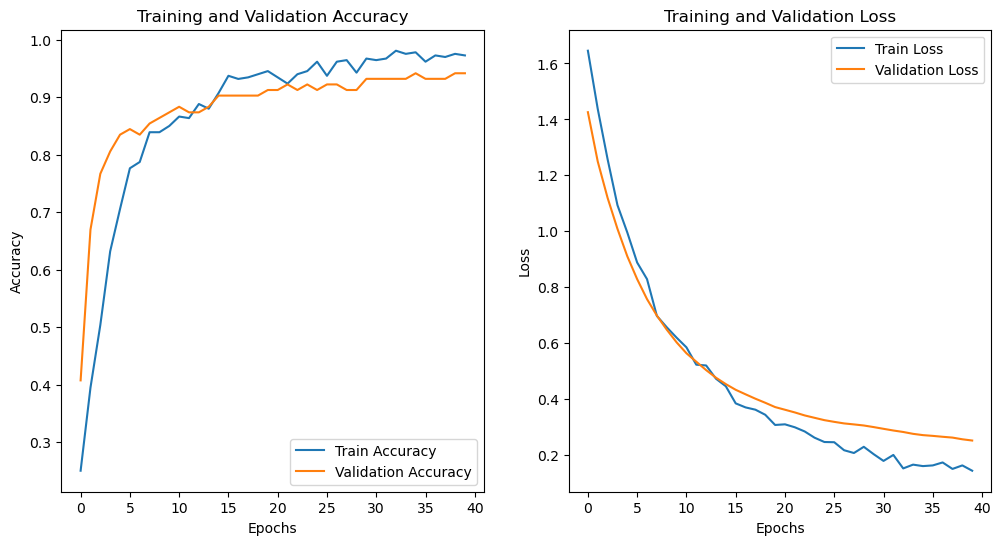

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(
    X_train, y_train,  
    epochs=40,  
    batch_size=32,  
    validation_data=(X_val, y_val), 
    callbacks=[early_stop] 
)

import tensorflow as tf


model.save("food_classifier_model.h5")  


plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


The left graph shows accuracy, where both training and validation accuracy increase steadily and reach above 90%, indicating strong learning. The right graph displays loss, with both training and validation loss decreasing consistently, suggesting effective optimization. The close alignment of training and validation curves indicates minimal overfitting, meaning the model generalizes well to unseen data. 

### D: Model Evaluation

I evaluate my trained CNN model's performance using several metrics. First, I make predictions on the test set and convert the predicted probabilities into class labels. Then, I generate a confusion matrix to compare the predicted and true labels, visualizing it with a heatmap.

Next, I calculate key metrics such as accuracy, precision, recall and F1 Score, which balances precision and recall. 

2/2 [==============================] - 4s 609ms/step


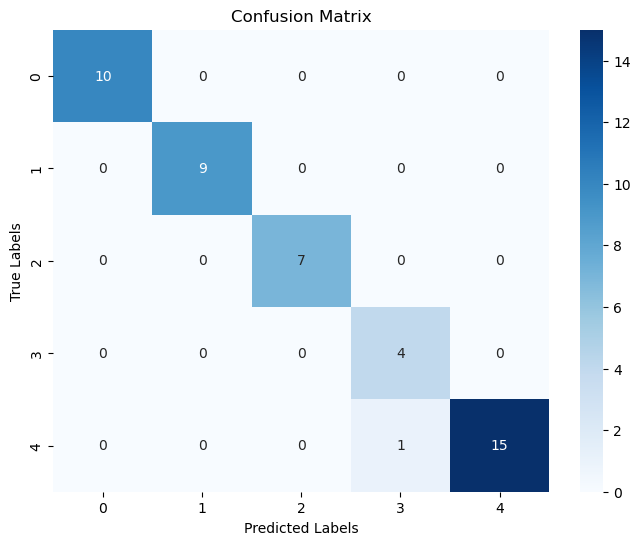

Accuracy: 0.9783
Precision: 0.9826
Recall: 0.9783
F1 Score: 0.9791


In [372]:
import seaborn as sns
import numpy as np

# Prediction
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = y_test   

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_true, y_pred_classes, average='weighted')  
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred_classes, average='weighted') 
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_true, y_pred_classes, average='weighted') 
print(f"F1 Score: {f1:.4f}")

The model achieved an accuracy of 0.9783, a precision of 0.9826, a recall of 0.9783, and an F1 score of 0.9791. It misclassified only one image, which demonstrates strong performance. Compared to iteration 3, the model's performance has improved with the updated dataset and slight modifications to the architecture. The new dataset, which includes more realistic images, likely contributed to the better generalization of the model, while the small changes in the architecture helped enhance the overall accuracy and robustness of the model.

## Task 3.7: Error Analysis

### A: Wrong Classifications

First, I generate predictions on the test set using the trained model. The predicted class labels are obtained by applying np.argmax to the output of the model, which provides the index of the highest probability for each prediction. I then compare these predicted labels with the actual labels (y_test) to identify where the model made mistakes.

To investigate the misclassifications, I use np.where to find the indices where the predicted labels do not match the actual labels. These mismatches are then stored in the variable wrong_predictions, and I collect the corresponding actual labels as well.

I display the first 9 misclassified images by iterating over the wrong predictions and using matplotlib to plot them. For each image, I include a title that shows the true label and the predicted label, which helps to visually assess the errors. The axis is turned off for cleaner visual representation.

Additionally, I print out the total number of incorrect predictions, providing an overview of the model's performance on the test set.

In iteration 3, I began by printing the misclassified images to analyze where the model struggled. In iteration 4, after refining the dataset and adjusting the architecture, I repeated the process to evaluate whether the model improved. The process of reviewing misclassifications helped identify patterns and areas for further improvement, which contributed to enhancing the model's performance in iteration 4.

2/2 [==============================] - 2s 494ms/step


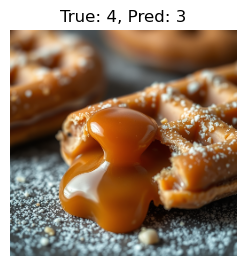

Number of incorrect predictions: 1


In [373]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# Predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = y_test

# Finding instances where predictions do not match labels
mismatches = np.where(predicted_labels != actual_labels)[0]

# Storing the wrong predictions
wrong_predictions = X_test[mismatches]
wrong_actual_labels = actual_labels[mismatches]
   

plt.figure(figsize=(10, 10))

for i, idx in enumerate(wrong_predictions[:9]):  # Displaying first 9 wrong predictions
    plt.subplot(3, 3, i+1)
    plt.imshow(idx) 
    plt.title(f"True: {wrong_actual_labels[i]}, Pred: {predicted_labels[mismatches[i]]}") 
    plt.axis('off')

plt.show()

print(f"Number of incorrect predictions: {len(wrong_predictions)}")


### B: Identify Error Types

Iteration 3: 
From the 7 displayed images I can conclude that the possible causes of errors were: 
Unrepresentativness - Some generated pictures may not accurately reflect typical characteristics of their food category
Color variation  - The color of the food item in some images may differ from the expected color range in the training data, the model focuses too much on the colour of the background
Similar visual features - Some foods (e.g., poffertjes and stroopwafels) share similar textures and colors, increasing confusion.


Iteration 4: 
One of the key reasons for misclassification in my model appears to be Inter-Class Similarity.
The model incorrectly classified Bitterballen as Kroket. This misclassification is likely due to the visual resemblance between the two food items in the dataset. Both classes share similar textures, colors, and shapes, making it challenging for the model to distinguish between them.

### C: Categorize Errors


Iteration 3: 

Similar-looking classes (2 errors, 28%) - Image 3, 5
    
Unrepresentative images (4 errors, 57%) - Image 1, 2, 4, 7
    
Color variation issues (1 errors, 14%) - Image 6

Iteration 4: 

Inter-Class Similarity - 100%

### D: Propose Improvements

One major cause of misclassification in Iteration 4 was the use of AI-generated images for all dataset samples. These images did not accurately capture real-world food textures, lighting conditions, and details. As a result, the model struggled to generalize when tested on actual food images, leading to a high number of errors.

Another significant factor was underrepresentation of real-world variations in the dataset. The dataset lacked the diversity needed for the model to distinguish between similar-looking foods. This issue contributed to frequent misclassifications.

After the dataset was revised in Iteration 4, by removing the AI-generated images and replacing them with real-world examples, model accuracy improved significantly. However, a single misclassification still occurred. The remaining error happened because stroopwafel was misclassified as poffertjes, likely due to similar colors, textures, and lighting conditions between these two food items. 

Future improvements based on findings: 

To improve classification accuracy, it is essential to reduce AI-generated images from the training dataset. These images do not always reflect real-world variations in food appearance. Training on such images can mislead the model, making it less effective when encountering real-world examples.

A key improvement is to increase dataset diversity by collecting more real-world food images. These images should include variations in lighting, angles, and ingredient differences to help the model learn more robust features. Additionally, applying data augmentation techniques, such as color shifting and contrast adjustments, can further improve the model’s ability to handle different lighting conditions.

Another step is to enhance feature learning for similar-looking food classes. Since stroopwafels and poffertjes share common visual characteristics, the model should be trained using different learning techniques to better differentiate between them. 